In [1]:
from itertools import combinations
import numpy as np
import sys
from oxDNA_analysis_tools.UTILS.oxview import oxdna_conf, from_path
from oxDNA_analysis_tools.UTILS.RyeReader import describe, get_confs, inbox
from oxDNA_analysis_tools.UTILS.data_structures import TopInfo, TrajInfo
from pathlib import Path
import os
from ipy_oxdna.dna_structure import DNAStructure, DNAStructureStrand, load_dna_structure, DNABase, strand_from_info
from copy import deepcopy
from ipy_oxdna.oxdna_simulation import Simulation, SimulationManager
import copy
from tqdm.auto import tqdm


In [2]:
# path = '/home/ava/Dropbox (ASU)/temp/Metabackbone/structure_files/six_helix_oxdna_file/unmodified/1512_bp'
# file_dir = os.path.join(path,'eq')

# path2 = '/home/azare3/metabackbone/python_scratch_work/simulate_and_calc_angles/simulations/1512/modified/'
# sim_dir = os.path.join(path2,'prod')

# sim = Simulation(file_dir, sim_dir)

# top_path = sim.sim_files.top
# traj_path = sim.sim_files.traj

# top, traj = describe(top_path, traj_path)

# # use the get_confs function to get the conformations postiions info read into python memory
# confs = get_confs(top , traj , 0, traj.nconfs)


In [3]:
path = '/home/ava/Dropbox (ASU)/temp/Metabackbone/structure_files/six_helix_oxdna_file/unmodified/1512_bp'
dat_path = os.path.join(path,'1512_bp.dat')
top_path = os.path.join(path,'1512_bp.top')


In [4]:
# downloading the structure 
dna = load_dna_structure(top_path, dat_path)      # dna is an instance of DNAstructure object               

In [5]:
def find_longest_strand(dna):
    longest_strand = None
    longest_strand_index = -1
    max_length = 0
    
    for index, strand in enumerate(dna.strands):
        if len(strand.bases) > max_length:
            max_length = len(strand.bases)
            longest_strand = strand
            longest_strand_index = index
    
    return longest_strand, longest_strand_index

In [6]:
longest_strand, longest_strand_index = list(find_longest_strand(dna))
# print(longest_strand)
# print(longest_strand_index)
# print(len(longest_strand.bases))
# print(longest_strand[0])
# print(longest_strand[1])
# print(longest_strand[0].uid)


In [7]:
def find_cross_over_in_longest_strand(dna):
    min_distance = float('inf')
    max_index_difference = 0
    cross_over_bases_max = (None, None)
    num_bases = len(longest_strand)

    # Iterate over all pairs of bases in the DNA strand
    for i in range(num_bases):
        for j in range(i + 1, num_bases):
            base_i = longest_strand[i]
            base_j = longest_strand[j]
            index_difference = abs(base_i.uid - base_j.uid)
            distance = np.linalg.norm(np.array(base_i.pos) - np.array(base_j.pos))

            # Update if the index difference is the largest seen so far
            if index_difference > max_index_difference or (index_difference == max_index_difference and distance < min_distance):
                max_index_difference = index_difference
                min_distance = distance
                cross_over_bases_max = (base_i, base_j)
            
   
    # Find pairs that have almost the same distance as min_distance and are in the close vicinity
    similar_distance_pairs = []
    distance_tolerance = 0.1 * min_distance
    vicinity_tolerance = 1.0  # Adjust this value as needed

    for i in range(num_bases):
        for j in range(i + 1, num_bases):
            base_i = longest_strand[i]
            base_j = longest_strand[j]
            distance = np.linalg.norm(np.array(base_i.pos) - np.array(base_j.pos))
            
            # Check if the distance is within the tolerance range of the min_distance
            if abs(distance - min_distance) <= distance_tolerance:
                
                # Check if the bases are in the vicinity of the cross_over_bases_max pair
                dist_to_max_0 = np.linalg.norm(np.array(base_i.pos) - np.array(cross_over_bases_max[0].pos))
                dist_to_max_1 = np.linalg.norm(np.array(base_j.pos) - np.array(cross_over_bases_max[1].pos))

                if dist_to_max_0 <= vicinity_tolerance and dist_to_max_1 <= vicinity_tolerance:
                    # Avoid selecting the same pair as cross_over_bases_max
                    if {base_i.uid, base_j.uid} != {cross_over_bases_max[0].uid, cross_over_bases_max[1].uid}:
                        similar_distance_pairs.append((base_i, base_j, distance))
    
             
              
    # Select two pairs closest to the min_distance
    similar_distance_pairs_sorted = sorted(similar_distance_pairs, key=lambda x: abs(x[2] - min_distance))
    closest_pairs = similar_distance_pairs_sorted[:2] # Get up to two closest pairs
    
    
    crossover_positions = [cross_over_bases_max[0].pos, cross_over_bases_max[1].pos]
    closest_pairs_positions = [(pair[0].pos, pair[1].pos) for pair in closest_pairs]
    
    
    # print('cross_over_bases_max:', cross_over_bases_max)
    # print()
    # print("cross_over_bases_max[0]:", cross_over_bases_max[0])
    # print()
    # print("cross_over_bases_max[1]:", cross_over_bases_max[1])
    # print()
    # print("cross_over_bases_max[0]_pos:", cross_over_bases_max[0].pos)
    # print()
    # print("cross_over_bases_max[1]_pos:", cross_over_bases_max[1].pos)
    # print()
    # print('similar_distance_pairs:', similar_distance_pairs)
    # print()
    # print('similar_distance_pairs[0]:', similar_distance_pairs[0])
    # print()
    # print('similar_distance_pairs[1]:', similar_distance_pairs[1])
    # print()
    # print('similar_distance_pairs[2]:', similar_distance_pairs[2])
    # print()
    # print('closest_pair:', closest_pairs)
    # print()
    # print('closest_pair[0]:', closest_pairs[0])
    # print()
    # print('closest_pair[1]:', closest_pairs[1])
    # print()
    # print("max_index_difference:", max_index_difference)
    # print()
    # print("min_distance:", min_distance)
    # print()
    
    # # Print the elements of the closest pairs separately
    # for idx, (base_i, base_j, dist) in enumerate(closest_pairs):
    #     print(f"Closest pair {idx + 1}:")
    #     print(f"  Base 1: UID = {base_i.uid}, Position = {base_i.pos}")
    #     print(f"  Base 2: UID = {base_j.uid}, Position = {base_j.pos}")
    #     print(f"  Distance: {dist}\n")

    return cross_over_bases_max, max_index_difference, min_distance, closest_pairs, crossover_positions, closest_pairs_positions



In [8]:
cross_over_bases_max, max_index_difference, min_distance, closest_pairs, crossover_positions, closest_pairs_positions = find_cross_over_in_longest_strand(dna)

# # Print all pairs in closest_pairs
# if closest_pairs:
#     for index, pair in enumerate(closest_pairs):
#         base1, base2, distance = pair
#         print(f"Pair {index + 1}:")
#         print(f"  Base 1: UID = {base1.uid}, Position = {base1.pos}")
#         print(f"  Base 2: UID = {base2.uid}, Position = {base2.pos}")
#         print(f"  Distance: {distance}\n")
# else:
#     print("The closest_pairs list is empty.")

# Pair base1 of the first pair with base2 of the second pair and measure the distance
if len(closest_pairs) >= 2:
    # Get the first and second pairs from the closest_pairs list
    first_pair = closest_pairs[0]
    second_pair = closest_pairs[1]

    # Extract base1 from the first pair and base2 from the second pair
    base1_first_pair = first_pair[0]
    base2_second_pair = second_pair[1]

    # Calculate the distance between base1 of the first pair and base2 of the second pair
    distance_between_bases_1_2 = np.linalg.norm(
        np.array(base1_first_pair.pos) - np.array(base2_second_pair.pos)
    )

    # Print the details of the bases and the calculated distance
    print("\nPairing base1 of the first pair with base2 of the second pair:\n")
    print(f"Base 1 (First Pair): UID = {base1_first_pair.uid}, Position = {base1_first_pair.pos}")
    print(f"Base 2 (Second Pair): UID = {base2_second_pair.uid}, Position = {base2_second_pair.pos}")
    print(f"Distance between them: {distance_between_bases_1_2}\n")
else:
    print("\nNot enough pairs in the closest_pairs list to perform the operation.\n")

# Pair base2 of the first pair with base1 of the second pair and measure the distance
if len(closest_pairs) >= 2:
    base2_first_pair = first_pair[1]
    base1_second_pair = second_pair[0]

    distance_between_bases_2_1 = np.linalg.norm(
        np.array(base2_first_pair.pos) - np.array(base1_second_pair.pos)
    )

    print("\nPairing base2 of the first pair with base1 of the second pair:\n")
    print(f"Base 2 (First Pair): UID = {base2_first_pair.uid}, Position = {base2_first_pair.pos}")
    print(f"Base 1 (Second Pair): UID = {base1_second_pair.uid}, Position = {base1_second_pair.pos}")
    print(f"Distance between them: {distance_between_bases_2_1}\n")
else:
    print("\nNot enough pairs in the closest_pairs list to perform the operation.\n")

# Pair base2 of the first pair with base2 of the second pair and measure the distance
if len(closest_pairs) >= 2:
    base2_first_pair = first_pair[1]
    base2_second_pair = second_pair[1]

    distance_between_bases_2_2 = np.linalg.norm(
        np.array(base2_first_pair.pos) - np.array(base2_second_pair.pos)
    )

    print("\nPairing base2 of the first pair with base2 of the second pair:\n")
    print(f"Base 2 (First Pair): UID = {base2_first_pair.uid}, Position = {base2_first_pair.pos}")
    print(f"Base 2 (Second Pair): UID = {base2_second_pair.uid}, Position = {base2_second_pair.pos}")
    print(f"Distance between them: {distance_between_bases_2_2}\n")
else:
    print("\nNot enough pairs in the closest_pairs list to perform the operation.\n")

# Pair base1 of the first pair with base1 of the second pair and measure the distance
if len(closest_pairs) >= 2:
    base1_first_pair = first_pair[0]
    base1_second_pair = second_pair[0]

    distance_between_base1s = np.linalg.norm(
        np.array(base1_first_pair.pos) - np.array(base1_second_pair.pos)
    )

    print("\nPairing base1 of the first pair with base1 of the second pair:\n")
    print(f"Base 1 (First Pair): UID = {base1_first_pair.uid}, Position = {base1_first_pair.pos}")
    print(f"Base 1 (Second Pair): UID = {base1_second_pair.uid}, Position = {base1_second_pair.pos}")
    print(f"Distance between them: {distance_between_base1s}\n")
else:
    print("\nNot enough pairs in the closest_pairs list to perform the operation.\n")





Pairing base1 of the first pair with base2 of the second pair:

Base 1 (First Pair): UID = 43, Position = [ 2.10507846 -0.6867429   0.12683482]
Base 2 (Second Pair): UID = 1554, Position = [2.37799716 0.69653118 0.12683482]
Distance between them: 1.4099403509855792


Pairing base2 of the first pair with base1 of the second pair:

Base 2 (First Pair): UID = 1051, Position = [ 2.0472362   0.69488323 -0.26292804]
Base 1 (Second Pair): UID = 1050, Position = [ 2.45607257 -0.73044026 -0.26292804]
Distance between them: 1.4827994516512886


Pairing base2 of the first pair with base2 of the second pair:

Base 2 (First Pair): UID = 1051, Position = [ 2.0472362   0.69488323 -0.26292804]
Base 2 (Second Pair): UID = 1554, Position = [2.37799716 0.69653118 0.12683482]
Distance between them: 0.5111952810836146


Pairing base1 of the first pair with base1 of the second pair:

Base 1 (First Pair): UID = 43, Position = [ 2.10507846 -0.6867429   0.12683482]
Base 1 (Second Pair): UID = 1050, Position =

In [9]:
# # Output the results
# print(f"Cross-over bases with max index difference: {cross_over_bases_max}")
# print(f"Largest index difference: {max_index_difference}")
# print(f"Smallest distance with max index difference: {min_distance}")
# print("Two pairs with distances close to the min distance in the close vicinity:")
# for pair in closest_pairs:
#     print(f"Bases: ({pair[0].uid}, {pair[1].uid}), Distance: {pair[2]}")


In [10]:

left_indices = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,1390,1391,1392,1393,1394,1395,1396,1397,1398,1399,1400,1401,1402,1403,1404,1405,1406,1407,1408,1409,1410,1411,1412,1413,1414,1415,1416,1417,1418,1419,1420,1421,1422,1423,1424,1425,1426,1427,1428,1429,1430,1431,1432,1433,1434,1435,1436,1437,1438,1439,1440,1441,1442,1443,1444,1445,1446,1447,1448,1449,1450,1451,1452,1453,1454,2293,2294,2295,2301,2302,2303,2304,2305,2306,2307,2308,2309,2310,2311,2312,2313,2314,2315,2316,2317,2318,2319,2320,2321,2322,2323,2324,2325,2326,2327,2328,2329,2330,2331,2332,2333,2334,2335,2336,2337,2338,2339,2340,2341,2342,2343,2344,2345,2346,2347,2348,2349,2350,2351,2352,2353,2354,2355,2356,2357,2358,2359,2360,2361,2362,2363,2364,2365,2366,2367,2368,2369,2370,2371,2372,2373,2374,2375,2376,2377,2378,2379,2380,2381,2783,2784,2785,2786,2787,2788,2789,2802,2803,2804,2805,2806,3011,3012,3013,3014,3015,3016,3017,3018,3019,3020,3021,3022,3023,3024,3025,3026,3027,3028,3029,3030,3031,3032,3033,3034,3035,3036,3037,3038,3039,3040,3041,3042,3043,3044,3045,3046,3047,3048,3049,3050,3051,3052,3053,3054,3055,3056,3057,3058,3059,3060,3061,3062,3063,3064,3065,3066,3067]
right_indices = [20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,875,876,877,878,879,880,881,882,883,884,885,886,887,888,889,890,891,892,893,894,895,896,897,898,899,900,901,902,903,904,905,906,907,908,909,910,911,912,913,914,915,916,917,918,919,920,921,922,923,924,925,926,927,928,929,930,931,932,933,934,935,936,937,938,939,940,941,942,943,944,945,946,947,948,949,950,951,952,953,954,955,956,957,958,959,960,961,962,1139,1140,1141,1142,1143,1144,1145,1146,1147,1148,1149,1150,1151,1152,1153,1154,1155,1156,1157,1158,1159,1160,1161,1162,1163,1164,1165,1166,1167,1168,1169,1170,1171,1172,1173,1174,1175,1176,1177,1178,1179,1180,1181,1182,1183,1184,1185,1186,1187,1188,1189,1190,1191,1192,1193,1194,1195,1196,1197,1198,1199,1555,1556,1557,1558,1559,1560,1561,1562,1563,1564,1565,1566,1567,1568,1569,1570,1571,1572,1573,1574,1575,1576,1577,1578,1579,1580,1581,1582,1583,1584,1585,1586,1587,1588,1589,1590,1591,1592,1593,1594,1595,1596,1597,1598,1599,1600,1601,1602,1603,1604,1605,1606,1607,1608,1609,1610,1611,1612,1613,1614,1615,1616,1617,1618,1619,1620,1621,1622,1623,1624,1625,1626,1627,1628,1629,1630,1631,1632,1633,1634,1635,1636,1637,1638,1639,1640,1641,1642,1643,1644,1645,1646,1647,1648,1649,1650,1651,1652,1653,1654,1655,1656,1657,1658,1667,1668,1669,1670,2382,2383,2384,2385,2386,2387,2388,2389,2390,2391,2392,2393,2394,2395,2396,2397,2398,2399,2400,2401,2402,2403,2404,2405,2406,2407,2408,2409,2410,2411,2412,2413,2414,2415,2416,2417,2418,2419,2420,2421,2422,2423,2424,2425,2426,2427,2428,2429,2430,2431,2432,2433,2434,2435,2436,2437,2438,2439,2440,2441,2442,2443,2444,2445,2446,2447,2448,2449,2450,2451,2452,2453,2454,2455,2456,2457,2458,2459,2460,2461,2462,2463,2464,2465,2466,2467,2479,2480,2481,2482,2483,2484,2491,2492,2493,2494,2495,2496,2497,2498,2499,2500,2501,2502,2818,2819,2820,2821,2822,2823]

def calculate_position(dna, left_indices, right_indices, t):
    left_pos = []
    right_pos = []
    
    # Collect positions for left indices
    for strand in dna.strands:
        for base in strand:
            if base.uid in left_indices:
                left_pos.append(base.pos)
    
    # Collect positions for right indices
    for strand in dna.strands:
        for base in strand:
            if base.uid in right_indices:
                right_pos.append(base.pos)
    
    # Debug prints to check the UIDs
    all_uids = [base.uid for strand in dna.strands for base in strand]
    # print(f"All base UIDs in DNA: {all_uids}")
    # print(f"Left indices: {left_indices}")
    # print(f"Right indices: {right_indices}")
    # print(f"Left positions found: {left_pos}")
    # print(f"Right positions found: {right_pos}")
    
    if left_pos:
        cms_left_side = np.mean(left_pos, axis=0)
    else:
        raise ValueError("No positions found for left indices.")
    
    if right_pos:
        cms_right_side = np.mean(right_pos, axis=0)
    else:
        raise ValueError("No positions found for right indices.")
    
    P = np.array(cms_left_side + t * (cms_right_side - cms_left_side))
    return P

In [11]:
P = calculate_position(dna, left_indices, right_indices, 0.5)
print("Point P on the axis:", P)

Point P on the axis: [0.05719734 0.06947511 1.17988527]


In [12]:
def find_valid_P(dna, left_indices, right_indices, cross_over_bases_max, closest_pairs_positions, sphere_radius):
    t_values = np.linspace(0, 1, 100)
    np.random.shuffle(t_values)
    
    crossover_positions = [cross_over_bases_max[0].pos, cross_over_bases_max[1].pos]
    tolerance_distance = sphere_radius / 2  # Adjust as needed

    for t in t_values:
        P = calculate_position(dna, left_indices, right_indices, t)
        far_enough = all(
            np.linalg.norm(P - np.array(pos)) > tolerance_distance
            for pos in crossover_positions
        )
        far_enough_pairs = all(
            np.linalg.norm(P - np.array(pair_pos[0])) > tolerance_distance and
            np.linalg.norm(P - np.array(pair_pos[1])) > tolerance_distance
            for pair_pos in closest_pairs_positions
        )

        if far_enough and far_enough_pairs:
            return P, t
    
    raise ValueError("Could not find a suitable P far enough from the crossover positions.")


In [13]:
sphere_radius = 3.5
cross_over_bases_max, max_index_difference, min_distance, closest_pairs, crossover_positions, closest_pairs_positions = find_cross_over_in_longest_strand(dna)
P, t = find_valid_P(dna, left_indices, right_indices, cross_over_bases_max, closest_pairs_positions, sphere_radius)
print(f"Selected point P: {P} at t={t}")

Selected point P: [  0.05066414  -0.11460527 -28.37566288] at t=0.8383838383838385


In [14]:
sphere_radius = 3.5

def find_bases_in_sphere(dna, P, sphere_radius):
    bases_in_sphere = []
    base_to_strand_mapping = {}
    
    for strand_index, strand in enumerate(dna.strands):
        for base in strand:
            base_position = np.array(base.pos)
            distance = np.linalg.norm(base_position - P)
            # print(f"Base UID: {base.uid}, Position: {base_position}, Distance to P: {distance}")

            if distance < sphere_radius:
                bases_in_sphere.append(base.uid)
                base_to_strand_mapping[base.uid] = strand_index
                # print(f"Base UID {base.uid} is within the sphere radius")
    
    return bases_in_sphere, base_to_strand_mapping

In [15]:
bases_in_sphere, base_to_strand_mapping = find_bases_in_sphere(dna, P, sphere_radius)
print('bases_in_sphere:', bases_in_sphere)
print('base_to_strand_mapping:', base_to_strand_mapping)
print('Number_bases_in_sphere:', len(bases_in_sphere))

bases_in_sphere: [609, 610, 611, 612, 613, 614, 615, 616, 715, 716, 717, 718, 719, 720, 721, 722, 723, 724, 725, 726, 727, 851, 852, 853, 854, 855, 856, 857, 858, 859, 860, 861, 862, 863, 864, 974, 975, 976, 977, 978, 979, 980, 981, 982, 1116, 1117, 1118, 1119, 1120, 1121, 1122, 1123, 1124, 1125, 1126, 1127, 1128, 1209, 1210, 1211, 1212, 1213, 1214, 1215, 1216, 1217, 1218, 1219, 1220, 1221, 1222, 1671, 1672, 1673, 1674, 1675, 1676, 1677, 1678, 1679, 1680, 1681, 1682, 1707, 1708, 1709, 1710, 1711, 1712, 1713, 1714, 1715, 1716, 1717, 1718, 1719, 1720, 1721, 1722, 1723, 1724, 1725, 1726, 1727, 1728, 1729, 1730, 1731, 1732, 1738, 1739, 1740, 2468, 2512, 2513, 2514, 2515, 2516, 2517, 2518, 2519, 2520, 2524, 2525, 2526, 2527, 2528, 2529, 2530, 2531, 2532, 2533, 2534, 2535, 2536, 2537, 2831, 2839, 2840, 2841, 2842, 2843]
base_to_strand_mapping: {609: 2, 610: 2, 611: 2, 612: 2, 613: 2, 614: 2, 615: 2, 616: 2, 715: 2, 716: 2, 717: 2, 718: 2, 719: 2, 720: 2, 721: 2, 722: 2, 723: 2, 724: 2, 725: 

In [16]:
def remove_strands_in_sphere(dna, P, sphere_radius):
    
    bases_in_sphere, base_to_strand_mapping = find_bases_in_sphere(dna, P, sphere_radius)
    longest_strand, longest_strand_index = find_longest_strand(dna)
    
    print(bases_in_sphere)
    print(base_to_strand_mapping)
    print(longest_strand)
    print(longest_strand_index)
    
    strands_to_remove = set(base_to_strand_mapping.values()) - {longest_strand_index}
    print(strands_to_remove)
    
    dna_structures = []
    
    for strand_index in strands_to_remove:
        strand_list = []
        
        for idx, strand in enumerate(dna.strands):
            if idx != strand_index:
                strand_list.append(strand)
        
        new_dna_structure = DNAStructure(strand_list, dna.time, dna.box, dna.energy)
        
        dna_structures.append(new_dna_structure)
        export_path = '/home/ava/Dropbox (ASU)/temp/Metabackbone/structure_files/six_helix_oxdna_file/Automatically_removed_staples/1512_bp'
        
        # Generate paths for exporting the new structure
        dat_path = os.path.join(export_path, '1512_bp_rmv_stpls.dat')
        top_path = os.path.join(export_path, '1512_bp_rmv_stpls.top')
        
        # Export the topology and configuration files
        new_dna_structure.export_top_conf(Path(top_path), Path(dat_path))
    
    return dna_structures

In [17]:
new_dna_structures = remove_strands_in_sphere(dna, P, sphere_radius)
print(new_dna_structures)
print(len(new_dna_structures))

[609, 610, 611, 612, 613, 614, 615, 616, 715, 716, 717, 718, 719, 720, 721, 722, 723, 724, 725, 726, 727, 851, 852, 853, 854, 855, 856, 857, 858, 859, 860, 861, 862, 863, 864, 974, 975, 976, 977, 978, 979, 980, 981, 982, 1116, 1117, 1118, 1119, 1120, 1121, 1122, 1123, 1124, 1125, 1126, 1127, 1128, 1209, 1210, 1211, 1212, 1213, 1214, 1215, 1216, 1217, 1218, 1219, 1220, 1221, 1222, 1671, 1672, 1673, 1674, 1675, 1676, 1677, 1678, 1679, 1680, 1681, 1682, 1707, 1708, 1709, 1710, 1711, 1712, 1713, 1714, 1715, 1716, 1717, 1718, 1719, 1720, 1721, 1722, 1723, 1724, 1725, 1726, 1727, 1728, 1729, 1730, 1731, 1732, 1738, 1739, 1740, 2468, 2512, 2513, 2514, 2515, 2516, 2517, 2518, 2519, 2520, 2524, 2525, 2526, 2527, 2528, 2529, 2530, 2531, 2532, 2533, 2534, 2535, 2536, 2537, 2831, 2839, 2840, 2841, 2842, 2843]
{609: 2, 610: 2, 611: 2, 612: 2, 613: 2, 614: 2, 615: 2, 616: 2, 715: 2, 716: 2, 717: 2, 718: 2, 719: 2, 720: 2, 721: 2, 722: 2, 723: 2, 724: 2, 725: 2, 726: 2, 727: 2, 851: 2, 852: 2, 853: 2

In [18]:
# Use the function
new_dna_structures = remove_strands_in_sphere(dna, P, sphere_radius)
print(new_dna_structures)
print()

print(len(new_dna_structures))
print()

for i, new_dna in enumerate(new_dna_structures):
    print(f"New DNA structure {i+1}:")
    print(new_dna.get_num_bases())
    print()

[609, 610, 611, 612, 613, 614, 615, 616, 715, 716, 717, 718, 719, 720, 721, 722, 723, 724, 725, 726, 727, 851, 852, 853, 854, 855, 856, 857, 858, 859, 860, 861, 862, 863, 864, 974, 975, 976, 977, 978, 979, 980, 981, 982, 1116, 1117, 1118, 1119, 1120, 1121, 1122, 1123, 1124, 1125, 1126, 1127, 1128, 1209, 1210, 1211, 1212, 1213, 1214, 1215, 1216, 1217, 1218, 1219, 1220, 1221, 1222, 1671, 1672, 1673, 1674, 1675, 1676, 1677, 1678, 1679, 1680, 1681, 1682, 1707, 1708, 1709, 1710, 1711, 1712, 1713, 1714, 1715, 1716, 1717, 1718, 1719, 1720, 1721, 1722, 1723, 1724, 1725, 1726, 1727, 1728, 1729, 1730, 1731, 1732, 1738, 1739, 1740, 2468, 2512, 2513, 2514, 2515, 2516, 2517, 2518, 2519, 2520, 2524, 2525, 2526, 2527, 2528, 2529, 2530, 2531, 2532, 2533, 2534, 2535, 2536, 2537, 2831, 2839, 2840, 2841, 2842, 2843]
{609: 2, 610: 2, 611: 2, 612: 2, 613: 2, 614: 2, 615: 2, 616: 2, 715: 2, 716: 2, 717: 2, 718: 2, 719: 2, 720: 2, 721: 2, 722: 2, 723: 2, 724: 2, 725: 2, 726: 2, 727: 2, 851: 2, 852: 2, 853: 2

In [19]:
import os
from pathlib import Path

# Define the base path for export
base_path = '/home/ava/Dropbox (ASU)/temp/Metabackbone/structure_files/six_helix_oxdna_file/Automatically_removed_staples/1512_bp'

# Initialize a list to collect the output paths
output_paths = []

# Iterate over the new DNA structures and generate unique paths for each
for i, new_dna in enumerate(new_dna_structures):
    structure_id = i  # Unique identifier for each structure
    
    # Create a unique subdirectory for each new structure
    unique_subdir = os.path.join(base_path, f'structure_{structure_id}')
    os.makedirs(unique_subdir, exist_ok=True)
    
    # Generate paths for the .dat and .top files
    dat_path = os.path.join(unique_subdir, '1512_bp_rmv_bases.dat')
    top_path = os.path.join(unique_subdir, '1512_bp_rmv_bases.top')
    
    # Export the new DNA structure to the unique path
    new_dna.export_top_conf(Path(top_path), Path(dat_path))
    
    # Collect the output paths
    output_paths.append({
        'structure_id': structure_id,
        'dat_path': dat_path,
        'top_path': top_path
    })

# Print the collected output paths for verification
print(output_paths)


[{'structure_id': 0, 'dat_path': '/home/ava/Dropbox (ASU)/temp/Metabackbone/structure_files/six_helix_oxdna_file/Automatically_removed_staples/1512_bp/structure_0/1512_bp_rmv_bases.dat', 'top_path': '/home/ava/Dropbox (ASU)/temp/Metabackbone/structure_files/six_helix_oxdna_file/Automatically_removed_staples/1512_bp/structure_0/1512_bp_rmv_bases.top'}, {'structure_id': 1, 'dat_path': '/home/ava/Dropbox (ASU)/temp/Metabackbone/structure_files/six_helix_oxdna_file/Automatically_removed_staples/1512_bp/structure_1/1512_bp_rmv_bases.dat', 'top_path': '/home/ava/Dropbox (ASU)/temp/Metabackbone/structure_files/six_helix_oxdna_file/Automatically_removed_staples/1512_bp/structure_1/1512_bp_rmv_bases.top'}, {'structure_id': 2, 'dat_path': '/home/ava/Dropbox (ASU)/temp/Metabackbone/structure_files/six_helix_oxdna_file/Automatically_removed_staples/1512_bp/structure_2/1512_bp_rmv_bases.dat', 'top_path': '/home/ava/Dropbox (ASU)/temp/Metabackbone/structure_files/six_helix_oxdna_file/Automatically_r

In [20]:
# Define paths and parameters
base_path = '/home/ava/Dropbox (ASU)/temp/Metabackbone/structure_files/six_helix_oxdna_file/Automatically_removed_staples/1512_bp'
sim_base_path = '/home/ava/Dropbox (ASU)/temp/Metabackbone/metabackbone/notebooks/Simulations/simulations/Automatically_rmvd_staples/1512_bp'
eq_steps = 1e7
prod_steps = 1e9
rel_steps = 1e5

eq_parameters = {
    'dt': '0.003', 'steps': f'{eq_steps}', 'print_energy_every': '1e5',
    'interaction_type': 'DNA2', 'print_conf_interval': '1e5', 'fix_diffusion': 'false',
    'T': '20C', 'max_density_multiplier': '50'
}

prod_parameters = {
    'dt': '0.003', 'steps': f'{prod_steps}', 'print_energy_every': '1e5',
    'interaction_type': 'DNA2', 'print_conf_interval': '1e5', 'fix_diffusion': 'false',
    'T': '20C', 'max_density_multiplier': '50'
}

rel_parameters = {'steps': f'{rel_steps}'}

simulation_manager = SimulationManager()
sim_list_rel = []

# Create simulation paths and add to list
for i, new_dna in enumerate(new_dna_structures):
    structure_id = i
    file_dir = os.path.join(base_path, f'structure_{structure_id}')
    sim_path = os.path.join(sim_base_path, f'1512_bp_{structure_id}')
    rel_dir = os.path.join(sim_path, 'relaxed')
    sim_list_rel.append(Simulation(file_dir, rel_dir))
    
for sim in sim_list_rel:
    
    sim.build(clean_build='force')
    sim.input.swap_default_input("cpu_MC_relax")
    sim.input_file(rel_parameters)
    simulation_manager.queue_sim(sim)


simulation_manager = SimulationManager()
sim_list_eq = []    
# Create simulation paths and add to list
for i, new_dna in enumerate(new_dna_structures):
    structure_id = i
    file_dir = os.path.join(base_path, f'structure_{structure_id}')
    sim_path = os.path.join(sim_base_path, f'1512_bp_{structure_id}')
    eq_dir = os.path.join(sim_path, 'eq')
    sim_list_eq.append(Simulation(file_dir, eq_dir))

for sim in sim_list_eq:
    sim.build(clean_build='force')
    sim.input.swap_default_input("cpu_MC_relax")
    sim.input_file(eq_parameters)
    simulation_manager.queue_sim(sim)
    
simulation_manager = SimulationManager()
sim_list_prod = []    
# Create simulation paths and add to list
for i, new_dna in enumerate(new_dna_structures):
    structure_id = i
    file_dir = os.path.join(base_path, f'structure_{structure_id}')
    sim_path = os.path.join(sim_base_path, f'1512_bp_{structure_id}')
    prod_dir = os.path.join(sim_path, 'prod')
    sim_list_prod.append(Simulation(file_dir, prod_dir))

for sim in sim_list_prod:
    sim.build(clean_build='force')
    sim.input.swap_default_input("cpu_MC_relax")
    sim.input_file(prod_parameters)
    simulation_manager.queue_sim(sim)




In [21]:
simulation_manager.run(gpu_mem_block= False)

spawning


In [22]:
for sim in sim_list_rel:
    sim.analysis.plot_energy()

Running: prod
Running: prod
Running: prod
Running: prod
Running: prod
Running: prod


/home/ava/Dropbox (ASU)/temp/Metabackbone/metabackbone/notebooks/Simulations/simulations/Automatically_rmvd_staples/1512_bp/1512_bp_0/relaxed: No energy file avalible
/home/ava/Dropbox (ASU)/temp/Metabackbone/metabackbone/notebooks/Simulations/simulations/Automatically_rmvd_staples/1512_bp/1512_bp_1/relaxed: No energy file avalible
/home/ava/Dropbox (ASU)/temp/Metabackbone/metabackbone/notebooks/Simulations/simulations/Automatically_rmvd_staples/1512_bp/1512_bp_2/relaxed: No energy file avalible
/home/ava/Dropbox (ASU)/temp/Metabackbone/metabackbone/notebooks/Simulations/simulations/Automatically_rmvd_staples/1512_bp/1512_bp_3/relaxed: No energy file avalible
/home/ava/Dropbox (ASU)/temp/Metabackbone/metabackbone/notebooks/Simulations/simulations/Automatically_rmvd_staples/1512_bp/1512_bp_4/relaxed: No energy file avalible
/home/ava/Dropbox (ASU)/temp/Metabackbone/metabackbone/notebooks/Simulations/simulations/Automatically_rmvd_staples/1512_bp/1512_bp_5/relaxed: No energy file avalibl

In [23]:
for sim in sim_list_eq:
    sim.analysis.plot_energy()

/home/ava/Dropbox (ASU)/temp/Metabackbone/metabackbone/notebooks/Simulations/simulations/Automatically_rmvd_staples/1512_bp/1512_bp_0/eq: No energy file avalible
/home/ava/Dropbox (ASU)/temp/Metabackbone/metabackbone/notebooks/Simulations/simulations/Automatically_rmvd_staples/1512_bp/1512_bp_1/eq: No energy file avalible
/home/ava/Dropbox (ASU)/temp/Metabackbone/metabackbone/notebooks/Simulations/simulations/Automatically_rmvd_staples/1512_bp/1512_bp_2/eq: No energy file avalible
/home/ava/Dropbox (ASU)/temp/Metabackbone/metabackbone/notebooks/Simulations/simulations/Automatically_rmvd_staples/1512_bp/1512_bp_3/eq: No energy file avalible
/home/ava/Dropbox (ASU)/temp/Metabackbone/metabackbone/notebooks/Simulations/simulations/Automatically_rmvd_staples/1512_bp/1512_bp_4/eq: No energy file avalible
/home/ava/Dropbox (ASU)/temp/Metabackbone/metabackbone/notebooks/Simulations/simulations/Automatically_rmvd_staples/1512_bp/1512_bp_5/eq: No energy file avalible


/home/ava/Dropbox (ASU)/temp/Metabackbone/metabackbone/notebooks/Simulations/simulations/Automatically_rmvd_staples/1512_bp/1512_bp_2/prod: No energy file avalible
/home/ava/Dropbox (ASU)/temp/Metabackbone/metabackbone/notebooks/Simulations/simulations/Automatically_rmvd_staples/1512_bp/1512_bp_3/prod: No energy file avalible
/home/ava/Dropbox (ASU)/temp/Metabackbone/metabackbone/notebooks/Simulations/simulations/Automatically_rmvd_staples/1512_bp/1512_bp_4/prod: No energy file avalible
/home/ava/Dropbox (ASU)/temp/Metabackbone/metabackbone/notebooks/Simulations/simulations/Automatically_rmvd_staples/1512_bp/1512_bp_5/prod: No energy file avalible


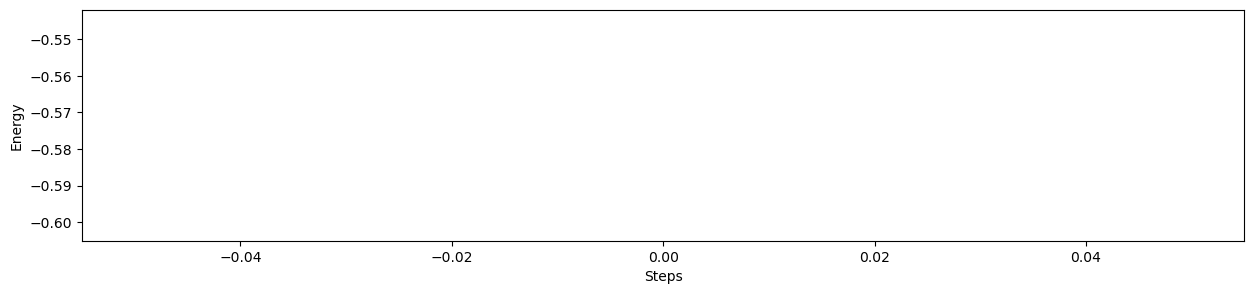

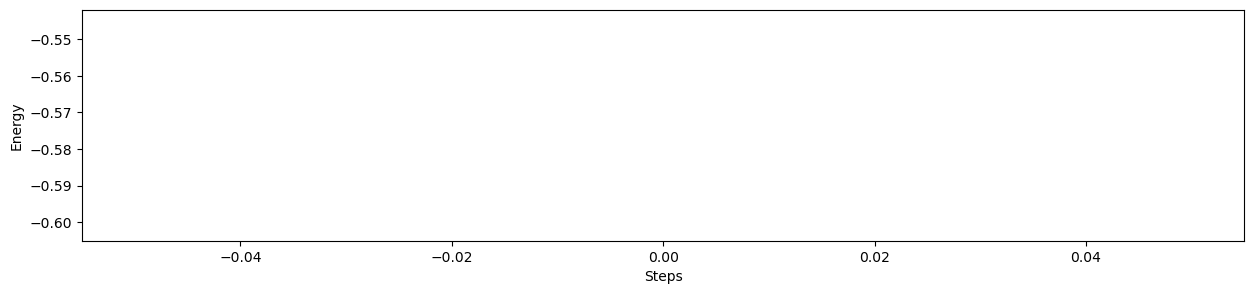

In [24]:
for sim in sim_list_prod:
    sim.analysis.plot_energy()

In [25]:
# Calculate angle between vectors
def calculate_angle_between_vectors(v1, v2):
    cos_theta = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
    angle_rad = np.arccos(cos_theta)
    angle_deg = np.degrees(angle_rad)
    return angle_deg

# Measure the joint angle
def measure_joint_angle(new_dna, P, distance_from_P=5.0):
    left_pos = [base.pos for strand in new_dna.strands for base in strand if base.uid in left_indices]
    right_pos = [base.pos for strand in new_dna.strands for base in strand if base.uid in right_indices]

    if not left_pos or not right_pos:
        raise ValueError("Left or right positions not found.")
    
    point_left = min(left_pos, key=lambda pos: np.linalg.norm(pos - P) > distance_from_P)
    point_right = min(right_pos, key=lambda pos: np.linalg.norm(pos - P) > distance_from_P)

    v1 = point_left - P
    v2 = point_right - P

    angle = calculate_angle_between_vectors(v1, v2)
    return angle

# Measure angles for all new structures
angles = []

for new_dna_structure in new_dna_structures:
    angle = measure_joint_angle(new_dna_structure, P)
    angles.append(angle)
    print(f"Measured angle: {angle}")

print("All measured angles:", angles)


Measured angle: 174.40914949950633
Measured angle: 174.40914949950633
Measured angle: 174.40914949950633
Measured angle: 174.40914949950633
Measured angle: 174.40914949950633
Measured angle: 174.40914949950633
All measured angles: [174.40914949950633, 174.40914949950633, 174.40914949950633, 174.40914949950633, 174.40914949950633, 174.40914949950633]
